In [176]:
 # Import libraries
import pandas as pd
import pickle as pk

# import libraries for api
import os
from dotenv import load_dotenv 
import requests
import json

# import libraries for vizualization
import seaborn as sns
import holoviews as hv
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import panel as pn
from pprint import pprint

In [96]:
#from Thomas's code 

filename = "Zillow_data"
infile = open(filename,'rb')
new_dict = pk.load(infile)
infile.close()
z_for_sale_resp =new_dict.json()
current_zillow_df = pd.json_normalize(data=z_for_sale_resp["props"])
print('num of rows:', len(current_zillow_df))
print('num of columns:', len(current_zillow_df.columns))

current_zillow_df.head()

num of rows: 40
num of columns: 18


,bathrooms,propertyType,lotAreaValue,address,imgSrc,price,listingDateTime,listingStatus,zpid,longitude,latitude,lotAreaUnit,daysOnZillow,bedrooms,country,currency,livingArea,hasImage
0,2,SINGLE_FAMILY,1742.40,"318 W Ruscomb St, Philadelphia, PA 19120",https://photos.zillowstatic.com/fp/c528e4507f6...,150000,None,FOR_SALE,10428068,-75.130410,40.026787,sqft,-1,4,USA,USD,1440,True
1,2,SINGLE_FAMILY,3920.40,"4913 Castor Ave, Philadelphia, PA 19124",https://photos.zillowstatic.com/fp/84229141ec1...,325000,None,FOR_SALE,10291269,-75.091110,40.024803,sqft,-1,4,USA,USD,1920,True
2,4,SINGLE_FAMILY,0.43,"200 W Walnut Ln, Philadelphia, PA 19144",https://photos.zillowstatic.com/fp/b90b6b03745...,869000,None,FOR_SALE,2068504637,-75.181816,40.037050,acres,-1,5,USA,USD,3857,True
3,4,SINGLE_FAMILY,9583.20,"2320 N 50th St, Philadelphia, PA 19131",https://photos.zillowstatic.com/fp/458505836a3...,267000,None,FOR_SALE,10486635,-75.227104,39.996180,sqft,-1,5,USA,USD,4520,True
4,3,SINGLE_FAMILY,3049.20,"522 Gilham St, Philadelphia, PA 19111",https://photos.zillowstatic.com/fp/04cc332dd77...,144000,None,FOR_SALE,2071261604,-75.092926,40.050960,sqft,-1,5,USA,USD,2007,True


In [97]:
#thomas code
zpid_list = current_zillow_df["zpid"].tolist()
current_zillow_df.columns
### Select columns that we will need for the analysis
current_zillow_df.columns
current_price_df = current_zillow_df[[ "zpid","propertyType" , "price", "livingArea" , "bathrooms" , "bedrooms" ,"address", "listingStatus" , "latitude" , "longitude", "imgSrc"]].copy()
current_price_df.set_index("zpid", inplace=True)


#Pull only the zip code from the address column
current_price_df["address"] = current_price_df["address"].str[-5:]

# Change the column names to improve readability
current_price_df.rename(columns = {
        "livingArea" : "Area in sqft.",
        "propertyType" : "Type of Property",
        "address" : "zip code",
        "listingStatus" : "Status",
        "imgSrc" : "Image property"
        }, inplace = True)


In [98]:
#thomas code
filename = "Zillow_old_data"
infile = open(filename,'rb')
new_source = pk.load(infile)
infile.close()
z_recently_sold_resp =new_source.json()
sold_zillow_df = pd.json_normalize(data=z_recently_sold_resp)
print('num of rows:', len(sold_zillow_df))
print('num of columns:', len(sold_zillow_df.columns))
sold_zillow_df.columns
sold_price_df = sold_zillow_df[[ "zpid", "homeType", "lastSoldPrice", "livingArea" , "bathrooms" , "bedrooms" , "address.zipcode",  "homeStatus" , "latitude" , "longitude", "miniCardPhotos"]].copy()
sold_price_df.set_index("zpid", inplace=True)

# Change the column names to improve readability
sold_price_df.rename(columns = {
        "homeType" : "Type of Property",
        "lastSoldPrice" : "Price",
        "livingArea" : "Area in sqft.",
        "address.zipcode" :"zip code",
        "homeStatus" : "Status",
        "miniCardPhotos" : "Image property"
        }, inplace = True)

num of rows: 5
num of columns: 18


In [99]:
#Add new columns in dataframes for "price per sqft"
current_price_df["price_per_sqft"] = current_price_df["price"] / current_price_df["Area in sqft."]

sold_price_df["price_per_sqft"] = sold_price_df["Price"] / sold_price_df["Area in sqft."]



In [100]:
#Add a variable for the ZPID. Add a variable "Purchase_house" to be the ZPID of the house we are looking to buy. 
ZPID = '10285435'
Purchase_house = current_price_df.loc[[ZPID]]
Purchase_house

,Type of Property,price,Area in sqft.,bathrooms,bedrooms,zip code,Status,latitude,longitude,Image property,price_per_sqft
zpid,,,,,,,,,,,
10285435,SINGLE_FAMILY,458900,1984,3,4,19119,FOR_SALE,40.052326,-75.193275,https://photos.zillowstatic.com/fp/f5cca126d4e...,231.300403


In [101]:
# Add variables for the average price per square foot/bedrooms/bathrooms of the comparable properties
# This is based on properties that requier to be in similar already (only one zipcode in table sold_price_df)

sold_average_price_per_sqft = sold_price_df['price_per_sqft'].mean()
sold_average_sqft = sold_price_df['Area in sqft.'].mean()
sold_average_bathrooms = sold_price_df['bathrooms'].mean()
sold_average_bedrooms = sold_price_df['bedrooms'].mean()

In [102]:
# Add variables for the price per square foot/bedrooms/bathrooms of the home we are looking to buy
Purchase_house_price_per_sqft = round(Purchase_house.loc[ZPID,'price_per_sqft'],2)
Purchase_house_sqft = round(Purchase_house.loc[ZPID,'Area in sqft.'],2)
Purchase_house_bathrooms = round(Purchase_house.loc[ZPID,'bathrooms'],2)
Purchase_house_bedrooms = round(Purchase_house.loc[ZPID,'bedrooms'],2)

In [103]:
# Add variables that are the difference per square foot/bedrooms/bathrooms of the comparables price per sqft vs. the house we want to buy
difference_price_per_sqft = round((sold_average_price_per_sqft - Purchase_house_price_per_sqft),2)
difference_sqft = round((sold_average_sqft - Purchase_house_sqft),2)
difference_bathrooms = round((sold_average_bathrooms - Purchase_house_bathrooms), 2)
difference_bedrooms = round((sold_average_bedrooms - Purchase_house_bedrooms), 2)

In [104]:
# Add a variable for our estimated Fair Value of the home we are looking to buy ( comparables average price per sq ft * purchase home sq ft)
Calculated_Home_Value = round((sold_average_price_per_sqft *  Purchase_house_sqft))

In [105]:
# Add a function to return our recommendation 
def recommendation(): 
    if sold_average_price_per_sqft > Purchase_house_price_per_sqft:
        return(f"We estimate the fair value of this house to be ${Calculated_Home_Value}. This house is ${difference_sqft} per square foot less expensive than comparable properties. We recommend you buy this house.")
    else:
        return(f"We estimate the fair value of this house to be ${Calculated_Home_Value}. This house is ${difference_sqft} per square foot more expensive than comparable properties. We don't recommend you buy this house.")
recommendation()

recommendation_text = recommendation()
recommendation_text

"We estimate the fair value of this house to be $421773. This house is $248.6 per square foot more expensive than comparable properties. We don't recommend you buy this house."

In [106]:
# Add functions to return other statistics on sqft
def other_info_sqft(): 
    if sold_average_sqft > Purchase_house_sqft:
        return(f"The property you are looking to buy has {difference_sqft: .2f} fewer square feet than the average of the comparables.")
    elif sold_average_sqft == Purchase_house_sqft:
        return(f"The property you are looking to buy has the same amount of square feet as the average of the comparable properties.")
    else:
        return(f"The property you are looking to buy has {difference_sqft: .2f} more square feet than the average of the comparables.")

other_info_sqft_text = other_info_sqft()

In [107]:
# Add functions to return other statistics on bathrooms
def other_info_bathrooms(): 
    if sold_average_bathrooms > Purchase_house_bathrooms:
        return(f"The property you are looking to buy has {difference_bathrooms: .2f} fewer bathrooms than the average of the comparables.")
    elif sold_average_bathrooms == Purchase_house_bathrooms:
        return(f"The property you are looking to buy has the same amount of bathrooms as the average of the comparable properties.")
    else:
        return(f"The property you are looking to buy has {difference_bathrooms: .2f} more bathrooms than the average of the comparables.")

other_info_bathrooms_text = other_info_bathrooms()

In [108]:
# Add functions to return other statistics on bedrooms
def other_info_bedrooms(): 
    if sold_average_bathrooms > Purchase_house_bathrooms:
        return(f"The property you are looking to buy has {difference_bedrooms: .2f} more bedrooms than the average of the comparables.")
    elif difference_bedrooms == 0.0:
        return(f"The property you are looking to buy has the same amount of bedrooms as the average of the comparable properties.")
    else:
        return(f"The property you are looking to buy has {difference_bedrooms: .2f} fewer bedrooms than the average of the comparables.")

other_info_bedrooms_text = other_info_bedrooms()

In [109]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
from dash.dependencies import Input, Output

ModuleNotFoundError: No module named 'dash'

In [110]:
file=open('HouseForSale.html',"w")
file.write(recommendation_text)
file.close()

In [111]:
#test


#app.layout = html.Div[html.Div([ 
    #html.Div([
       # dcc.Input(
         #   id='ZID'.format('text'),
         #   type='text',
         #   placeholder="insert {}".format('text'),
          #  debounce=True,
         #   minLength=0, maxLength=50,
          #  disabled=False,
         #   readOnly=False,
           # required=False,
         #   size="20"
   #     ) 
 #   ,
#
        
 #   ])
#])]

In [112]:
#test

#dff = df.copy()
#dff = dff[dff['ZID'] == ZID]
#print("ZID:" + str(ZID)

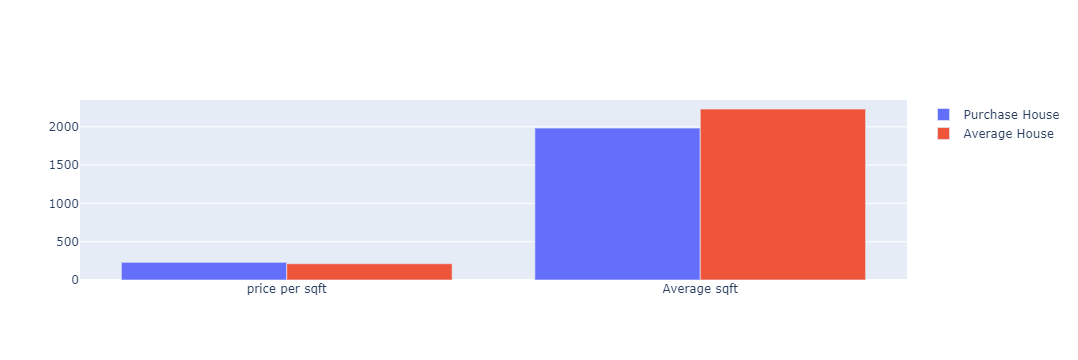

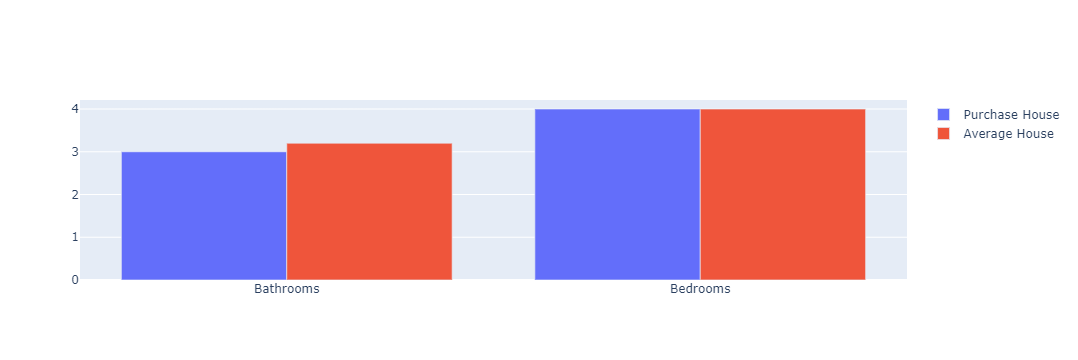

In [227]:
# Vizualisations
## First vizualisation : comparison of caracteristics between current house for sale and mean house profile sold
# Split caracteristics for each line of the plot
caracteristics_1 = ["price per sqft", "Average sqft"]
caracteristics_2 = ["Bathrooms",  "Bedrooms"]

# Set the first figure
fig1 = go.Figure(data=[
    go.Bar(name="Purchase House", x=caracteristics_1, y=[Purchase_house_price_per_sqft , Purchase_house_sqft]),
    go.Bar(name="Average House", x=caracteristics_1, y= [sold_average_price_per_sqft , sold_average_sqft ])
    ])

# Set the second figure
fig2 = go.Figure(data=[
    go.Bar(name="Purchase House", x=caracteristics_2, y=[ Purchase_house_bathrooms , Purchase_house_bedrooms]),
    go.Bar(name="Average House", x=caracteristics_2, y= [sold_average_bathrooms , sold_average_bedrooms ])
    ])

# Split each figure in two subfigures
fig1.update_layout(barmode='group')
fig2.update_layout(barmode='group')


# Show figure
fig1.show()
fig2.show()

<AxesSubplot:title={'center':' Price houses for sale by neighborhood'}, xlabel='zip code', ylabel=' Price per sqft'>

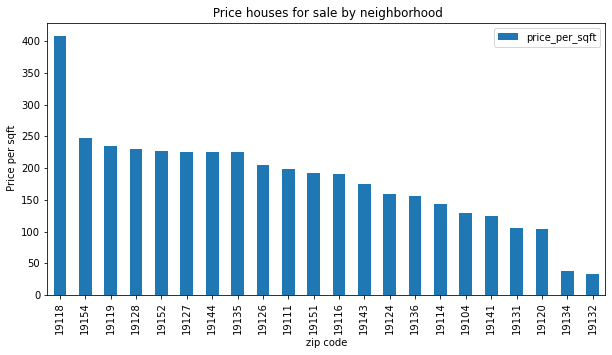

In [219]:
## Second vizualisation : prices of the different house by neighborhood and sort them
# Sort prices by mean price for each zip code in an descending order
current_price_by_neighborhood = current_price_df.groupby("zip code").mean()
current_price_by_neighborhood.reset_index(inplace=True)
current_price_by_neighborhood.sort_values("price_per_sqft", ascending=False, inplace=True)

# Plot image
current_price_by_neighborhood.plot.bar(x="zip code", y= "price_per_sqft", ylabel = " Price per sqft", title=" Price houses for sale by neighborhood", figsize =(10, 5))

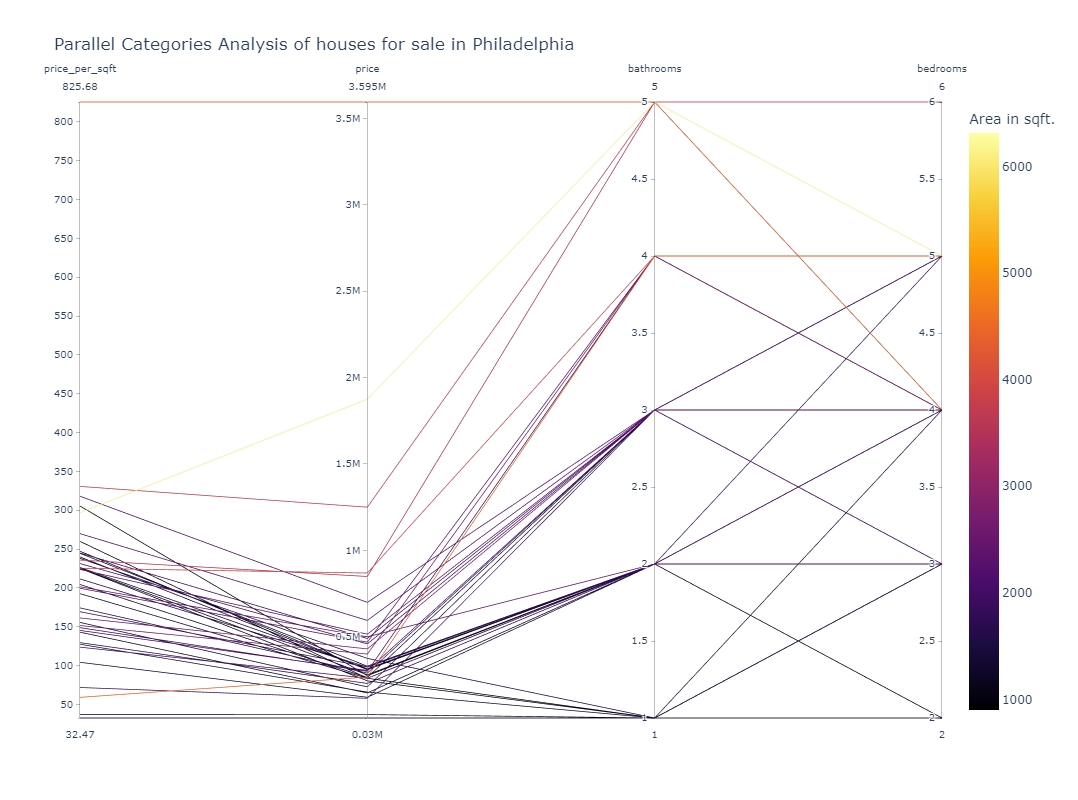

In [115]:
## Third vizualisation : Category plot for the houses, by neighborhood, beds, bathrooms, price

plt_categories = px.parallel_coordinates(
    current_price_df,
    dimensions= [  'price_per_sqft',  "price", "bathrooms" , "bedrooms"],
    title = "Parallel Categories Analysis of houses for sale in Philadelphia",
    color=  "Area in sqft.",
    color_continuous_scale= px.colors.sequential.Inferno,
    height = 800)
    
plt_categories.show()  


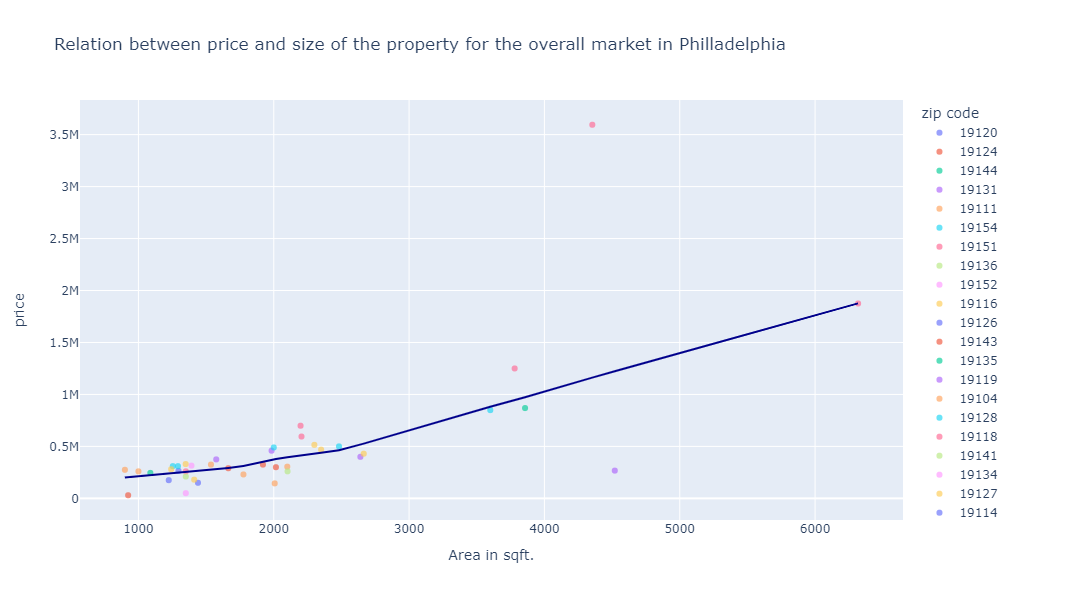

In [220]:
## Fourth vizualisation: price versius area 

fig_scatter = px.scatter(
    current_price_df,
    x="Area in sqft.",
    y="price",
    opacity=0.65,
    color = "zip code",
    trendline= "lowess",
    trendline_scope= "overall",
    trendline_color_override= "darkblue",
    title = "Relation between price and size of the property for the overall market in Philladelphia",
    height = 600
    )
fig_scatter.show()


In [228]:
## Fifth vizualisation: bell curve for the sold house
# Set title with variable ZPID in function of the search
title_content = f"Density curve for properties similar to property with ZPID :{ZPID}"

# Define two plots: the desnity and the value of the current house for sale defined by the ZPID.
denisty_curve = sold_price_df['price_per_sqft'].hvplot.kde(width=600, height = 400, title =title_content, hover_line_color="red", grid=True)
vline = hv.VLine(Purchase_house_price_per_sqft , label="vline")

# Join plots under a new variable name
density_plt = denisty*vline

density_plt



:Overlay
   .Distribution.I :Distribution   [price_per_sqft]   (Density)
   .VLine.Vline    :VLine   [x,y]